# Statistical Inference of Luminosity and Temperature of Dwarf Stars

### Ahmed Rizk, Cathy Liu, Divya Bilolikar, Olivia Pang

In [2]:
library(tidyverse)
library(infer)
library(gridExtra)
library(testthat)
library(digest)
library(broom)

Warning message:
"package 'tidyverse' was built under R version 4.1.2"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'tibble' was built under R version 4.1.2"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'purrr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.2"
Warning message:
"package 'stringr' was built under R version 4.1.2"
Warning message:
"package 'forcats' was built under R version 4.1.2"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() -

## Introduction

In this project we want to determine if there is a difference in luminosity and temperature between red, brown, and white dwarfs. Our location parameter is the mean of luminosity and temperature and our scale parameter is the standard deviation of both luminosity and temperature. We chose these because we have a large dataset (240 observations) and thus the CLT takes effect and we can treat the dataset as normally distributed.

Stars are typically classified into four different groups – white dwarfs, main sequence, giants, and supergiants. (Chiosi) A typical star will become a main sequence star and then end its life cycle as a white dwarf. As this is the most common type of star, this is the most frequent lifecycle that we see stars go through. (“Main Sequence Stars: Definition & Life Cycle.” ) Contrary to its name, red dwarfs are not a type of white dwarf, rather they are a type of small main sequence star that is not very bright. Similarly we have brown dwarves, these are not usually classified as stars because they do not burn hot enough. (“Red Dwarfs: The Most Common and Longest-Lived Stars.”) White dwarfs are very small dense stars that are not very bright when compared to main sequence stars. (Koester) When a massive star is formed it will become a giant star or a supergiant and then end its lifecycle as a neutron star or a blackhole. Giants and supergiants are very large stars (with supergiant being even larger) that shine very bright when compared to main sequence stars. (Chiosi)

While white, red, and brown dwarf stars share a name, they are very different and typically not classified together. This is clearly seen in an Hertzsprung-Russell diagram (a scatter plot that shows the trends in star types against luminosity, temperature, color, and magnitude) where white dwarves have their own classification (in the bottom left) and red and white dwarfs are lumped together in the main sequence group towards the bottom right. Since all three stars appear on the bottom half of the diagram we want to explore the difference in luminosity and temperature between the three.

The dataset that are using has the following variables

| Variable | Description |
| :-: | :-: |
| Absolute Temperature (K) | The temperature of the star in Kelvin |
| Relative Luminosity (L/Lo) | The luminosity of the star when divided by the average luminosity of the sun (3.828 x 10^26 Watts) |
| Relative Radius (R/Ro) | The radius of the star when divided by the average radius of the sun (6.9551 x 10^8 m) |
| Absolute Magnitude (Mv) | The absolute magnitude of the star |
| Star Color | The color of the star |
| Spectral Class (O,B,A,F,G,K,M) | If the star is a main sequence star, the type of main sequence star it is |
| Star Type (Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants) | The type of star it is | 

## Preliminary Analysis

### Reading the dataset into R

In [3]:
stars <- read.csv("6-class.csv")

glimpse(stars)

Rows: 240
Columns: 7
$ Temperature..K.        <int> 3068, 3042, 2600, 2800, 1939, 2840, 2637, 2600,~
$ Luminosity.L.Lo.       <dbl> 0.002400, 0.000500, 0.000300, 0.000200, 0.00013~
$ Radius.R.Ro.           <dbl> 0.17000, 0.15420, 0.10200, 0.16000, 0.10300, 0.~
$ Absolute.magnitude.Mv. <dbl> 16.120, 16.600, 18.700, 16.650, 20.060, 16.980,~
$ Star.type              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,~
$ Star.color             <chr> "Red", "Red", "Red", "Red", "Red", "Red", "Red"~
$ Spectral.Class         <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", "M~


### Cleaning and Wrangling

Since the target categorical variable for our analysis is the star type, we need to change it from type 'int' to type 'factor'.

In [4]:
stars <- mutate(stars, Star.type = as_factor(Star.type))

Next, we filter out the Giant stars (types 3, 4 and 5) to isolate the Dwarfs.

In [13]:
dwarfs <- stars %>%
filter(Star.type != 5) %>%
filter(Star.type != 4) %>%
filter(Star.type != 3)


### Visualizations

We can create boxplots to show the variation in luminosity and temperature across star types. This will give us a rough idea of the differences between each star type, and if there are any groups that are vastly different from the rest.

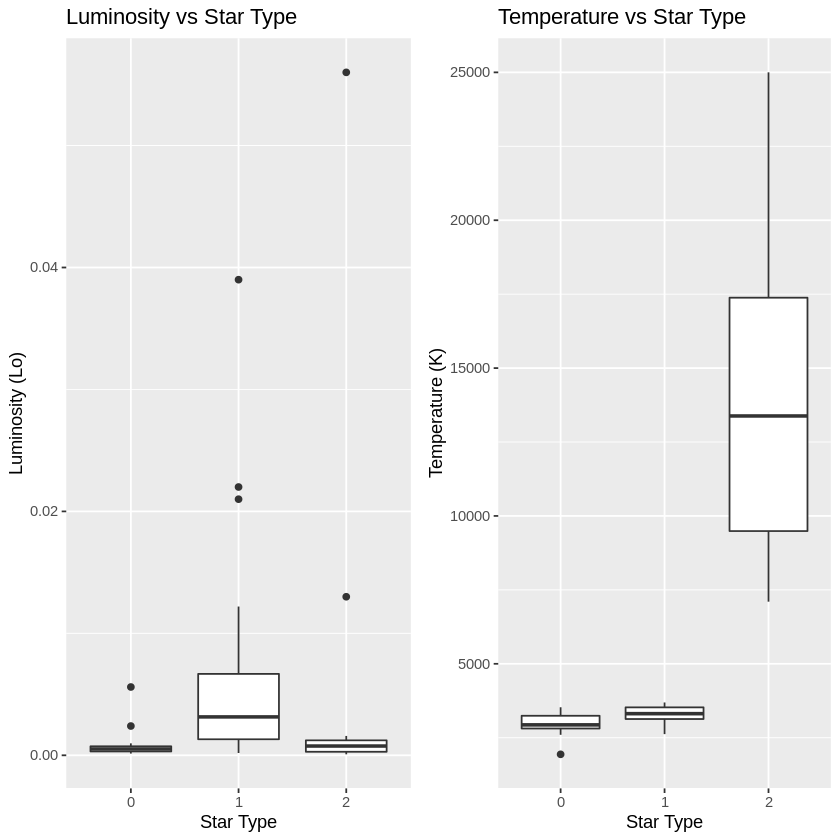

In [14]:
L_box <- ggplot(dwarfs, aes(x = Star.type, y = Luminosity.L.Lo.)) + geom_boxplot() + ggtitle("Luminosity vs Star Type") + xlab("Star Type") + ylab("Luminosity (Lo)")
T_box <- ggplot(dwarfs, aes(x = Star.type, y = Temperature..K.)) + geom_boxplot() +  ggtitle("Temperature vs Star Type") +  xlab("Star Type") + ylab("Temperature (K)")
grid.arrange(L_box, T_box, ncol=2)

In the figure above we can see the distributions of luminosity vs star type and temperature vs star type. We can see that the means of the luminosity across star types is very similar however the interquartile range of star type 1 is much larger. In the temperature vs star type graph we can see that the range and mean of star type  0 and 1 are very similar however both the mean and interquartile range of star type 2 is very large.

To find the within group distributions for each star type, we will separate the data into 3 different parts, each representing a star type.

In [15]:
type_0 <- filter(stars, Star.type == 0)
type_1 <- filter(stars, Star.type == 1)
type_2 <- filter(stars, Star.type == 2)

#### Brown Dwarf Distributions

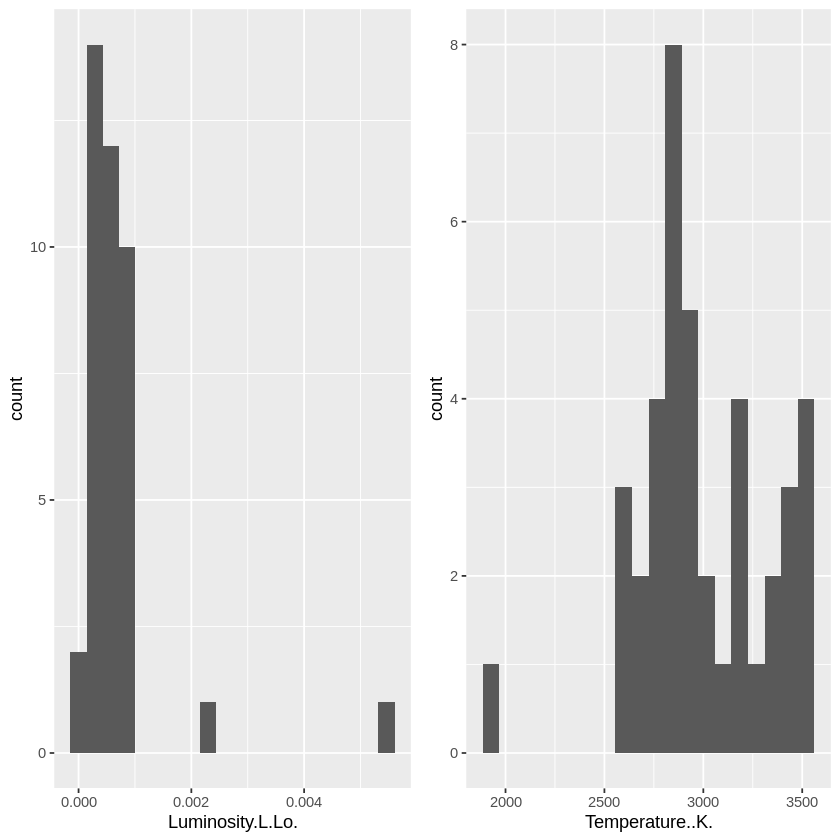

In [16]:
# Find the distribution of luminosity and temperature values for the brown dwarf star

L_0 <- ggplot(type_0, aes(x = Luminosity.L.Lo.)) + geom_histogram(bins = 20)
T_0 <- ggplot(type_0, aes(x = Temperature..K.)) + geom_histogram(bins = 20)
grid.arrange(L_0, T_0, ncol=2)

In the Luminosity graph above we can see that the distribution is unimodal and looks fairly normal with a few larger outlier. Most stars seem to have a luminosity between 0 and 0.001 LL_o. In the Temperature graph we can see that the dsitibution looks bimodal peaking at around 2800 K and 3500 K.

#### Red Dwarf Distributions

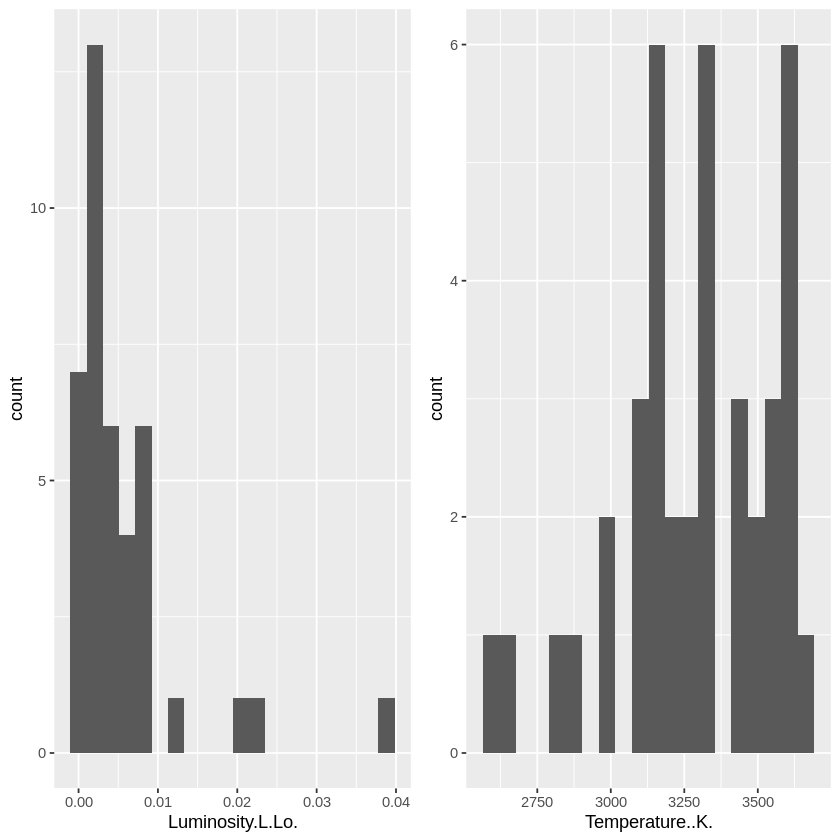

In [17]:
# Find the distribution of luminosity and temperature values for the red dwarf star

L_1 <- ggplot(type_1, aes(x = Luminosity.L.Lo.)) + geom_histogram(bins = 20)
T_1 <- ggplot(type_1, aes(x = Temperature..K.)) + geom_histogram(bins = 20)
grid.arrange(L_1, T_1, ncol=2)

In the Luminosity graph above we can see that the distribution is unimodal and looks fairly normal with a few larger outlier. Most stars seem to have a luminosity between 0 and 0.01 LL_o. In the Temperature graph we can see that the distribution looks unimodal peaking in the range of 3100K to 3500K.

#### White Dwarf Distributions

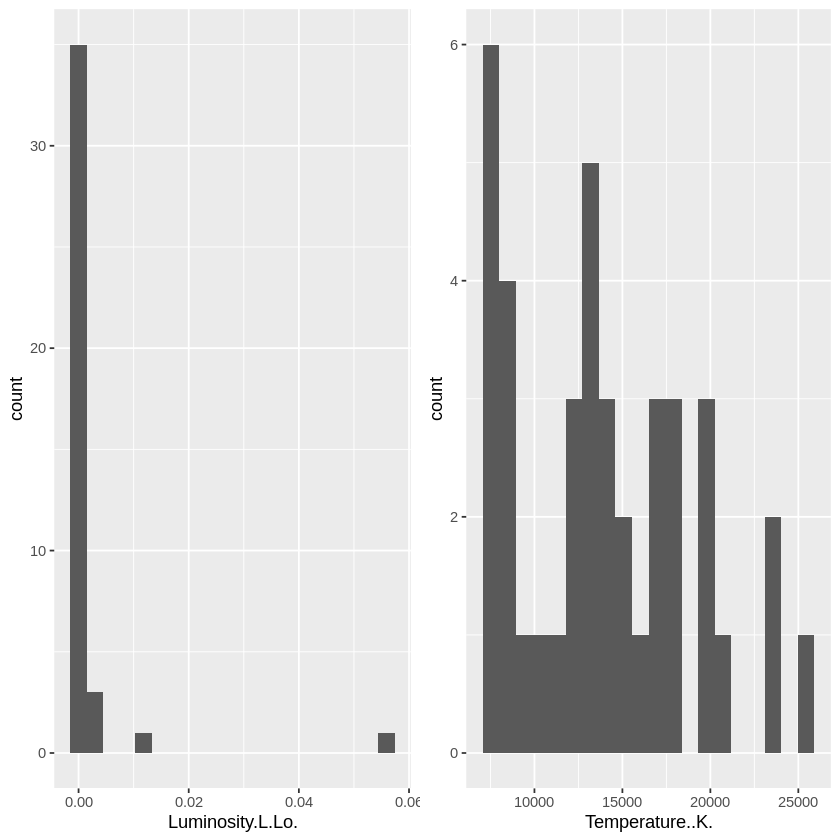

In [18]:
# Find the distribution of luminosity and temperature values for the white dwarf star

L_2 <- ggplot(type_2, aes(x = Luminosity.L.Lo.)) + geom_histogram(bins = 20)
T_2 <- ggplot(type_2, aes(x = Temperature..K.)) + geom_histogram(bins = 20)
grid.arrange(L_2, T_2, ncol=2)

In the Luminosity graph above we can see that the distribution is unimodal and looks fairly normal with a few larger outlier. Most stars seem to have a luminosity between 0 and 0.005 LL_o. In the Temperature graph we can see that the distribution looks right skewed uni modal.

### Computing Parameter Estimates

#### Brown Star Estimates

In [19]:
# Finding the mean and standard deviation of the luminosity and temperature of the brown star

brown_dwarf_stats <- type_0 %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              sd_lum = sd(Luminosity.L.Lo.),
              mean_temp = mean(Temperature..K.),
              sd_temp = sd(Temperature..K.)) %>%
    add_column(Type = "Brown", .before = "mean_lum")

brown_dwarf_stats

Type,mean_lum,sd_lum,mean_temp,sd_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Brown,0.000693275,0.0008879057,2997.95,332.2763


In [20]:
# Finding the mean and standard deviation of the luminosity and temperature of the red star

red_dwarf_stats <- type_1 %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              sd_lum = sd(Luminosity.L.Lo.),
              mean_temp = mean(Temperature..K.),
              sd_temp = sd(Temperature..K.)) %>%
    add_column(Type = "Red", .before = "mean_lum")

red_dwarf_stats

Type,mean_lum,sd_lum,mean_temp,sd_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Red,0.00540575,0.00733024,3283.825,269.6373


In [21]:
# Finding the mean and standard deviation of the luminosity and temperature of the white star

white_dwarf_stats <- type_2 %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              sd_lum = sd(Luminosity.L.Lo.),
              mean_temp = mean(Temperature..K.),
              sd_temp = sd(Temperature..K.)) %>%
    add_column(Type = "White", .before = "mean_lum")

white_dwarf_stats

Type,mean_lum,sd_lum,mean_temp,sd_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.002433625,0.008912496,13931.45,4957.655


In [22]:
# Combining all parameter estimates together

parameter_estimates <- rbind(brown_dwarf_stats, red_dwarf_stats, white_dwarf_stats)
parameter_estimates

Type,mean_lum,sd_lum,mean_temp,sd_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Brown,0.000693275,0.0008879057,2997.950,332.2763
Red,0.005405750,0.0073302401,3283.825,269.6373
White,0.002433625,0.0089124960,13931.450,4957.6552


## Methods

This report is trustworthy because the dataset that we use is fairly large, so it is potentially representative of the true population. Therefore the mean estimates that we have calculated can be good starting points to create confidence intervals for our population parameters. While our estimations are a good starting point, they are not enough to present to a stakeholder. The plots would be a better representation if we were to do some further data processing like bootstrapping or asymptotic testing. Additionally there is no way to estimate the sampling variability of the population of stars by examining point estimates of the standard deviation, or the distribution of values of the dataset. 

In order to address the gap we brought up above, we need to bootstrap to more closely approximate the actual distribution of the population, and by extension find a range of possible parameter estimates as opposed to a point estimate.
In the final report, we expect to find whether we are confident to say there is a difference in the luminosity and temperature between dwarf stars. We will express our result and the uncertainty in a trustworthy way. We believe finding this clarifies the difference in some features between different types of dwarf stars, and further increases the accuracy and reliability of star classification. This analysis leads to future questions such as “is there a difference in the magnitude between dwarf stars”. Additionally we can use these results to infer real astronomical observations.

Since our analysis will examine the means of 2 variables for 3 different groups, using 2 hypotheses would minimize the probability of making a type 1 error from the sample. We can carry this out by using an ANOVA test twice, one for the means of each variable.

# Bootstrap Analysis

In the following code cells we conduct a bootstrap on each of the different types of dwarf stars in order to find better estimates for the means and standard deviations of both luminosity and temperature. 

### Bootstrap on Temperature and Luminosity of Brown Dwarfs

In [41]:
brown_dwarf_stats <- type_0 %>% 
    rep_sample_n(size = 40, reps = 1000, replace = TRUE) %>% #Creating the bootstrap distribution. 
    group_by(replicate) %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), #Finding means and standard deviations of each sample. 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    summarise(mean_lum = mean(mean_lum), #Using means to summarizing the estimates. 
              mean_temp = mean(mean_temp), 
              SE_lum = mean(sd_lum), 
              SE_temp = mean(sd_temp)) %>%
    add_column(Type = "Brown", .before = "mean_lum")
brown_dwarf_stats

Type,mean_lum,mean_temp,SE_lum,SE_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Brown,0.0006888284,2998.272,0.0007878741,323.4307


### Bootstrap on Temperature and Luminosity of Red Dwarfs

In [35]:
red_dwarf_stats <- type_1 %>% 
    rep_sample_n(size = 40, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    summarise(mean_lum = mean(mean_lum), 
              mean_temp = mean(mean_temp), 
              SE_lum = mean(sd_lum), 
              SE_temp = mean(sd_temp)) %>%
    add_column(Type = "Red", .before = "mean_lum")
red_dwarf_stats

Type,mean_lum,mean_temp,SE_lum,SE_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Red,0.005450013,3284.724,0.007026764,265.2301


### Bootstrap on Temperature and Luminosity of White Dwarfs

In [36]:
white_dwarf_stats <- type_2 %>% 
    rep_sample_n(size = 40, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarise(mean_lum = mean(Luminosity.L.Lo.), 
              mean_temp = mean(Temperature..K.),
              sd_lum = sd(Luminosity.L.Lo.),
              sd_temp = sd(Temperature..K.)) %>%
    summarise(mean_lum = mean(mean_lum), 
              mean_temp = mean(mean_temp), 
              SE_lum = mean(sd_lum), 
              SE_temp = mean(sd_temp)) %>%
    add_column(Type = "White", .before = "mean_lum")
white_dwarf_stats

Type,mean_lum,mean_temp,SE_lum,SE_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.002459066,13937.92,0.007474539,4884.547


In [37]:
bootstrap_estimates <- rbind(brown_dwarf_stats, red_dwarf_stats, white_dwarf_stats)
bootstrap_estimates

Type,mean_lum,mean_temp,SE_lum,SE_temp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Brown,0.000690681,2997.675,0.0007887416,325.3435
Red,0.005450013,3284.724,0.0070267639,265.2301
White,0.002459066,13937.917,0.0074745386,4884.5467


# ANOVA

ANOVA (Analysis of Variance) is a test to determine whether the difference between means across three or more groups exist by analyzing the overall and within-group variance. ANOVA test calculates F-value, which is the ratio of the variability between group means and the variation within groups, and corresponding p-value. If F-value is significantly greater than 1, the p-value is going to be small, we conclude that the variability between group means exists. In this project, since our goal is to analyze the difference between temperature and luminosity of three groups of dwarf planets, ANOVA becomes very appropriate and effective. In this section, we will conduct two ANOVA tests across three dwarf groups on both variables, and analyze the results.


### ANOVA for Temperature Across all Three Dwarf Types

We start with temperature. Before actually starting the ANOVA test, we need to do a little bit of cleanup, select the columns that we want, which are Star Type and Temperature.

In [24]:
# filter out the target column Temperature to get the tidy data set
dwarfs_temp <- dwarfs %>%
               select(Temperature..K., Star.type)
head(dwarfs_temp)

,Temperature..K.,Star.type
,<int>,<fct>
1,3068,0
2,3042,0
3,2600,0
4,2800,0
5,1939,0
6,2840,0


In [25]:
# Perform ANOVA test and print the result table
anova_temp <- aov(Temperature..K.~Star.type, data = dwarfs_temp)%>%
              tidy()
print(anova_temp)

# A tibble: 2 × 6
  term         df       sumsq      meansq statistic   p.value
  <chr>     <dbl>       <dbl>       <dbl>     <dbl>     <dbl>
1 Star.type     2 3106600865. 1553300433.      188.  2.74e-37
2 Residuals   117  965696814.    8253819.       NA  NA       


In [26]:
# Filter out the F-value from the table above
# Filter out the p-value from the table above
f_stat_temp <- anova_temp %>%
          filter(term == "Star.type") %>%
          select(statistic) %>%
          as.numeric()
anova_pval_temp <- anova_temp %>%
              filter(term == "Star.type") %>%
              select(p.value) %>%
              as.numeric()
print(f_stat_temp)
print(anova_pval_temp)

[1] 188.1917
[1] 2.738892e-37


The F-value obtained is 188.91, and the p-value is 2.74e-37. In this case, our F-value is significantly greater than 1. Therefore, the variation between group means is clearly larger than the variation within groups, indicating that at least one of the mean value is different across three groups. The p-value also states the result. Since p-value is significantly smaller than the critical value (0.05), it falls in reject region. Therefore, by looking at the ANOVA test for temperature across three groups, we say at least one of the mean value is different across three groups and the temperature of three dwarf groups are not all same.

### ANOVA for Luminosity Across all Three Dwarf Types

In [27]:
# filter out the target column Luminosity to get the tidy data set
dwarfs_lumi <- dwarfs %>%
               select(Luminosity.L.Lo., Star.type)
head(dwarfs_lumi)

,Luminosity.L.Lo.,Star.type
,<dbl>,<fct>
1,0.002400,0
2,0.000500,0
3,0.000300,0
4,0.000200,0
5,0.000138,0
6,0.000650,0


In the following two blocks of code, we perform ANOVA test on luminosity across three groups of dwarfs.

In [28]:
# Perform ANOVA test and print the result table
anova_lumi <- aov(Luminosity.L.Lo.~Star.type, data = dwarfs_lumi)%>%
              tidy()
print(anova_lumi)

# A tibble: 2 × 6
  term         df    sumsq    meansq statistic  p.value
  <chr>     <dbl>    <dbl>     <dbl>     <dbl>    <dbl>
1 Star.type     2 0.000454 0.000227       5.09  0.00761
2 Residuals   117 0.00522  0.0000447     NA    NA      


In [29]:
# Filter out the F-value from the table above
# Filter out the p-value from the table above
f_stat_lumi <- anova_lumi %>%
          filter(term == "Star.type") %>%
          select(statistic) %>%
          as.numeric()
anova_pval_lumi <- anova_lumi%>%
              filter(term == "Star.type") %>%
              select(p.value) %>%
              as.numeric()
print(f_stat_lumi)
print(anova_pval_lumi)

[1] 5.086809
[1] 0.007614593


# Results

The F-value obtained is 5.09, and the p-value is 0.0076. Although we get a much smaller F-value than the F-value in temperature test, it still clearly larger than 1. The p-value is also smaller than the critical value (0.05), and falls in reject region. Although we might say the difference between luminosity across groups is not as significantly as the difference between temperature, we are still confident to say at least one mean value is different from others, and the luminosity of three dwarf groups are not all same.

# Discussion

The results of our temperature ANOVA test showed that we got a p-value of 2.74e-37. This is significantly less than our alpha level of 0.05. As a result we reject the Null Hypothesis and conclude that there is a difference in the mean temperature of stars across the three categories (brown dwarfs, red dwarfs, and white dwarfs). From this one way ANOVA test we cannot conclude how the means differ just that all three means are not the same.
 
The results of our luminosity ANOVA test showed that we got a p-value of 0.008. One again this is less than our alpha level of 0.05 and thus we reject the Null Hypothesis that the means of the luminosity are the same across all three star types. 

We expected these results because from our exploratory data analysis we could visually see that the means of the star types for both temperature and luminosity were very different. 

Even though the probability of a type I error is very small, we do not believe that we are at risk of committing a type II error. As the probability of type I error decreases, the probability of committing a type II error increases however we feel like that is offset by our large sample size.

## Implication of Findings

The results of our ANOVA test indicate that there do exist differences between the three types of dwarfs in terms of temperature and luminosity. We are now relatively confident that the three types of dwarfs do not have the same average temperature and luminosity. 
First of all, we believe this finding further clarifies the difference between dwarf stars, giving a better understanding of stars and celestial bodies in the universe. 

In the article Red dwarfs: The most common and longest-lived stars, the author states that there is no true definition of red dwarf; the classification just refers to dwarf stars with different spectral types (Tillman, 2019). Therefore, we hope our finding helps to improve the accuracy of the star classification system. We also believe that the results could be easily applied to the real-world situation when people are doing actual astronomical analysis. For example, if anyone tries to clarify between multiple groups of dwarf stars, the results of this project could help them make a meaningful guess based on temperature and luminosity data. 

Furthermore, the difference in temperature and luminosity could indicate the existence of other differences which have not yet been found by people. It leads to various research topics on the reasons that cause these differences and impact of these differences on our current knowledge of celestial bodies.

## Limitations of Analysis

There are several limitations of our analysis. The first limitation is that although using ANOVA would be far better at limiting the probability of type 1 error, our groups do not have roughly equal variances. The temperature of white stars has a variance of XXX which far exceeds that of the other 2 groups. A similar phenomenon is observed in the luminosity of brown stars, which is far less than the other 2 types. Therefore, our F-scores for both variables are somewhat inflated. 

A second limitation is that although our dataset is large enough (240 observations), our within-group distributions for the luminosity of white/brown/red stars are right skewed. Therefore, we might need a larger sample for the CLT to take effect for luminosity.


## Further Questions

Since our EDA points to which type of star varies in terms of the means and variances from the rest, a possible future analysis could be done to explore the temperatures and luminosities of the (red, brown) and the (red, white) stars respectively. 

Additionally we can also explore other star variables such as magnitude and color and see how their means differentiate.


# References

Chiosi, Cesare, Gianpaolo Bertelli, and Alessandro Bressan. "New developments in understanding the HR diagram." Annual review of astronomy and astrophysics 30.1 (1992): 235-285.

Koester, Detlev, and Ganesar Chanmugam. "Physics of white dwarf stars." Reports on Progress in Physics 53.7 (1990): 837.

Tillman, Nola Taylor, and Ben Biggs. “Main Sequence Stars: Definition & Life Cycle.” Space.com, Space, 26 Jan. 2022, https://www.space.com/22437-main-sequence-star.html. 

Tillman, Nola Taylor. “Red Dwarfs: The Most Common and Longest-Lived Stars.” Space.com, Space, 6 June 2019, https://www.space.com/23772-red-dwarf-stars.html. 